In LunarLanderContinious there are two actions possible (values in [-1,1])

- First action, main engine:
    - [-1..0] => off
    - [0..+1] => throttle from 50% to 100% power
    
- Second action
    - [-1.0..-0.5] => fire left engine
    - [+0.5..+1.0] => fire right engine
    - [-0.5..0.5] => off

In [25]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Flatten, Convolution2D
from keras.optimizers import sgd

import gym

# Custom files, please check repo
from _util import preprocess_env, phi
from memory import ReplayMemory

#  Initialization of environnement

In [3]:
env = gym.make('LunarLanderContinuous-v2')
env.reset()

INFO:gym.envs.registration:Making new env: LunarLanderContinuous-v2
[2017-01-06 19:23:39,895] Making new env: LunarLanderContinuous-v2


array([-0.00346727,  0.93801928, -0.3512104 , -0.17295194,  0.00402447,
        0.07955439,  0.        ,  0.        ])

# Define NN

In [31]:
nb_frames = 4

height = 80
width = 120

# We need to create bins for the number of actions, we have continuous values, for example here we need
# to specify the 10 actions we want to provide. We have to rediscuss this approach because we will be limited to 
# the actions we define...
nb_actions = 10 

hidden_size = 32

model = Sequential()
model.add(Convolution2D(8,8,8,input_shape = (nb_frames, height, width)))
model.add(Convolution2D(16,4,4))
model.add(Convolution2D(16,3,3))
model.add(Flatten())
model.add(Dense(hidden_size, activation='relu'))
model.add(Dense(nb_actions))

model.compile(sgd(lr=.2), "mse")
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_8 (Convolution2D)  (None, 8, 73, 113)    2056        convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
convolution2d_9 (Convolution2D)  (None, 16, 70, 110)   2064        convolution2d_8[0][0]            
____________________________________________________________________________________________________
convolution2d_10 (Convolution2D) (None, 16, 68, 108)   2320        convolution2d_9[0][0]            
____________________________________________________________________________________________________
flatten_3 (Flatten)              (None, 117504)        0           convolution2d_10[0][0]           
___________________________________________________________________________________________

# DQN with Experience replay
- We got an issue when game finishes, the model predicts a sequence of nan...


In [12]:
import tqdm

In [40]:
env.reset()

# Initialize replay memory D to capacity N
N  = 10
replay_memory = ReplayMemory(N)

# TODO Initialize action-value function Q with random weights, create bins because of continious function?


M = 1 # Number of episodes
T = 100 # To be defined
epsilon = 0.01 # Exploration
gamma = 0.7 

for episode in range(0,M):
    ## Initialise sequence s(1) = {x1}
    s = [preprocess_env(env)]

    for t in tqdm.tqdm(range(0,T)):
        
        
        # Choice of action
        if np.random.rand()<epsilon:
            # Choose action randomly
            action_t = np.random.rand(2)
        else:
            # Choose max(Q(a,s))\a
            ## TODO
            action_t = np.array([0,0])
        
            
        # Execute action at in emulator and observe reward rt and image xt+1
        observation, r_t, done, info = env.step(action_t)
        x_t_plus_1 = preprocess_env(env) # Renders, downsamples and converts to grayscale the gameview
        
        # Set st+1 = st; at; xt+1 
        tmp = s # st
        s.append(action_t)
        s.append(x_t_plus_1)
        
        # Store preprocessed with Phi transition Phi t , at, rt, Phi t+1  in D
        replay_memory.append([phi(tmp),action_t,r_t,phi(s)], env.game_over)
        
        # Sample random minibatch of transitions Phi j , aj , rj , Phi j+1  from D
        batch, batch_state = replay_memory.mini_batch(size = 4)
        
        x = []
        y = []
        for j,transition in enumerate(batch):
            
            if batch_state[j] == True:
                # Terminal j+1
                y.append(transition[2]) 
                env.reset()
            else:
                # Non-terminal j+1
                phi_j_plus_1 = np.array(batch[j][3])
                x.append(phi_j_plus_1)
                phi_j_plus_1 = phi_j_plus_1[None,:,:,:]
                
                
                output = model.predict(phi_j_plus_1)
                max_val = max(output)
                
                # rj + gamma * max a0 Q(j+1; a0; theta)
                y_j = np.array(transition[2]+gamma*max_val)
                y.append(y_j)
        
        x = np.array(x)
        y = np.array(y)
        
        #Perform a gradient descent step on (yj - Q(j ; aj ; theta))2 according to equation 3
        model.train_on_batch(x,y)

 89%|████████▉ | 89/100 [00:37<00:04,  2.37it/s]

Exception: Error when checking model target: expected dense_9 to have shape (None, 10) but got array with shape (4, 1)

In [48]:
%matplotlib inline

In [49]:
import matplotlib.pyplot as plt

In [51]:
phi_j_plus_1[0].shape

(4, 80, 120)

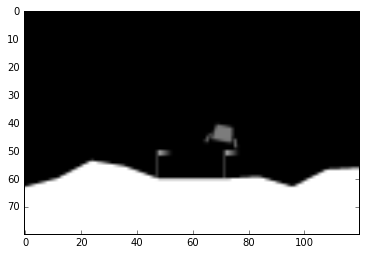

In [62]:
plt.imshow(phi_j_plus_1[0][1],cmap='gray')